## Pfam seed random split

In [1]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

tf.test.is_built_with_cuda()

tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Tensorflow version 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

True

In [2]:
tf.config.experimental.list_physical_devices('GPU')
#for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# import tensorflow.keras.backend as K
# dtype = 'float16'
# K.set_floatx(dtype)
# K.set_epsilon(1e-4)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [4]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn
import gc
import sklearn
import pickle

In [2]:
#ONLY RUN IF USING TORCH

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
torch.cuda.empty_cache() 

In [4]:
#ONLY RUN IF USING TORCH

from tape import ProteinBertModel, TAPETokenizer
model = ProteinBertModel.from_pretrained('bert-base')
modelTAPE = model.to(device)
tokenizerTAPE = TAPETokenizer(vocab='iupac')  # iupac is the vocab for TAPE models, use unirep for the UniRep model

In [5]:
pos_dirpath = './Pfam_fasta/positive'
neg_dirpath = './Pfam_fasta/negative'
print('Available files: ', os.listdir(pos_dirpath))

Available files:  ['pos_PF00555_seed_Endotoxin_M_36.txt', 'pos_PF01024_full_Colicin_26.txt', 'pos_PF01117_full_Aerolysin_207.txt', 'pos_PF01338_full_Bac_thur_toxin_87.txt', 'pos_PF01823_rp15_MACPF_659.txt', 'pos_PF03318_full_ETX_MTX2_440.txt', 'pos_PF03505_full_Clenterotox_9.txt', 'pos_PF03944_seed_Endotoxin_C_80.txt', 'pos_PF03945_full_Endotoxin_N_180.txt', 'pos_PF04877_full_Harpin_35.txt', 'pos_PF05105_seed_Phage_holin_4_1_131.txt', 'pos_PF05802_full_EspB_60.txt', 'pos_PF06109_full_HlyE_62.txt', 'pos_PF06355_full_Aegerolysin_308.txt', 'pos_PF06369_full_anemone_cytotox_363.txt', 'pos_PF07968_full_Leukocidin_89.txt', 'pos_PF11393_full_T4BSS_DotI_IcmL_214.txt', 'pos_PF12261_full_T_hemolysin_327.txt', 'pos_PF12563_full_Hemolysin_N_12.txt', 'pos_PF12920_full_TcdA_TcdB_pore_46.txt', 'pos_PF17475_full_Binary_toxB_2_16.txt', 'pos_PF18063_full_BB_PF_52.txt', 'pos_PF18684_full_PlyB_C_8.txt']


In [8]:
def parse_fasta (lines):
    descs = []
    seqs = []
    data = ''
    for line in lines:
        if line.startswith('>'):
            if data:   # have collected a sequence, push to seqs
                seqs.append(data)
                data = ''
            descs.append(line[1:])  # Trim '>' from beginning
        else:
            data += line.rstrip('\r\n')
    # there will be yet one more to push when we run out
    seqs.append(data)
    return descs, seqs

In [6]:
def parse_fasta_append (lines, seqs=[]):
    descs = []
    data = ''
    for line in lines:
        if line.startswith('>'):
            if data:   # have collected a sequence, push to seqs
                seqs.append(data)
                data = ''
            descs.append(line[1:])  # Trim '>' from beginning
        else:
            data += line.rstrip('\r\n')
    # there will be yet one more to push when we run out
    seqs.append(data)
    length = len(descs)
    return descs, seqs, length

In [7]:
pos_seqs = []
pos_labels = []
for fn in os.listdir(pos_dirpath):
    handle = open(os.path.join(pos_dirpath, fn), 'r')
    descs, pos_seqs, num_seq = parse_fasta_append(handle.read().split('\n'), pos_seqs)
    labs = [fn]*num_seq
    pos_labels.append(labs)
    handle.close()

In [8]:
len(pos_seqs)

3447

In [9]:
from itertools import chain
pos_labels = list(chain.from_iterable(pos_labels))
len(pos_labels)

3447

In [10]:
neg_seqs = []
neg_labels = []
for fn in os.listdir(neg_dirpath):
    handle = open(os.path.join(neg_dirpath, fn), 'r')
    descs, neg_seqs, num_seq = parse_fasta_append(handle.read().split('\n'), neg_seqs)
    labs = [fn]*num_seq
    neg_labels.append(labs)
    handle.close()

In [11]:
len(neg_seqs)

3393

In [12]:
neg_labels = list(chain.from_iterable(neg_labels))
len(neg_labels)

3393

In [13]:
#need to get rid of alignment since using that would be cheating

pos = []
neg = []

for seq in pos_seqs:
    s = seq.replace("-", "")
    s = s.replace(".", "")
    pos.append(s)

for seq in neg_seqs:
    s = seq.replace("-", "")
    s = s.replace(".", "")
    neg.append(s)

In [14]:
data = pos + neg
labels = pos_labels + neg_labels

from sklearn.model_selection import train_test_split
train, dev, train_labels, validation_labels = train_test_split(
    data,
    labels,
    test_size = 0.2,
    random_state=1,
    stratify=labels)

In [15]:
from collections import Counter

print(Counter(train_labels))
print(Counter(validation_labels))

Counter({'PF01823_rp15_MACPF_659.txt': 527, 'PF03494_full_Beta-APP_556.txt': 445, 'PF01702_seed_TGT_541.txt': 433, 'PF03318_full_ETX_MTX2_440.txt': 352, 'PF06369_full_anemone_cytotox_363.txt': 290, 'PF12261_full_T_hemolysin_327.txt': 262, 'PF06355_full_Aegerolysin_308.txt': 246, 'PF00019_seed_TGF_beta_291.txt': 233, 'PF09396_full_Thrombin_light_233.txt': 186, 'PF11393_full_T4BSS_DotI_IcmL_214.txt': 171, 'PF01117_full_Aerolysin_207.txt': 166, 'PF03945_full_Endotoxin_N_180.txt': 144, 'PF00870_rp15_P53_160.txt': 128, 'PF00377_full_Prion_159.txt': 127, 'PF00729_full_Viral_coat_149.txt': 119, 'PF00010_seed_HLH_146.txt': 117, 'PF05105_seed_Phage_holin_4_1_131.txt': 105, 'PF02793_seed_HRM_126.txt': 101, 'PF01049_seed_Cadherin_C_98.txt': 78, 'PF06083_seed_IL17_93.txt': 74, 'PF07968_full_Leukocidin_89.txt': 71, 'PF07733_seed_DNA_pol3_alpha_88.txt': 70, 'PF01338_full_Bac_thur_toxin_87.txt': 70, 'PF00992_seed_Troponin_87.txt': 70, 'PF17416_full_Glycoprot_B_PH1_82.txt': 66, 'PF03944_seed_Endotoxin

## Loading the data

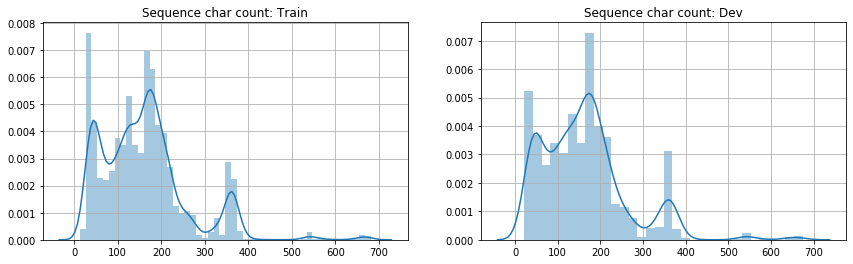

In [19]:
# Length of sequence in train data.
trainlen= [len(x) for x in train]
devlen= [len(x) for x in dev]

def plot_seq_count(lengths, data_name):
    seaborn.distplot(lengths)
    plt.title(f'Sequence char count: {data_name}')
    plt.grid(True)

plt.subplot(1, 3, 1)
plot_seq_count(trainlen, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(devlen, 'Dev')

plt.subplots_adjust(right=3.0)
plt.show()

In [20]:
print(max(trainlen))
print(max(devlen))

681
674


In [22]:
vocab_size = 21
max_length = 700
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"

trainTAPE = [tokenizerTAPE.encode(w.upper()) for w in train]
valTAPE = [tokenizerTAPE.encode(w.upper()) for w in dev]

TAPEtrain = pad_sequences(trainTAPE, maxlen=max_length, padding=padding_type)
TAPEvalidation = pad_sequences(valTAPE, maxlen=max_length, padding=padding_type)

In [23]:
len(TAPEtrain)

5472

In [24]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
batch_size = 2

dataloader_train = DataLoader(
    TAPEtrain,
    batch_size=batch_size
)

dataloader_validation = DataLoader(
    TAPEvalidation,
    batch_size=batch_size
)

In [25]:
del pos, neg, s, data, labels, neg_seqs, neg_labels, pos_seqs, pos_labels, trainTAPE, valTAPE, TAPEtrain, TAPEvalidation
gc.collect()

10975

In [39]:
torch.cuda.empty_cache() 

In [27]:
#tqdm does not work and throws notebook validation error..
TAPEncoded_train = []
iternum = 0
for batch in dataloader_train:
    b = batch.to(torch.long)
    output = modelTAPE(b.to(device))[1]
    TAPEncoded_train.append(output.cpu().detach().numpy())
    if iternum%100 == 0:
        print(iternum)
    iternum = iternum + 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700


In [28]:
TAPEncoded_val = []
iternum = 0
for batch in dataloader_validation:
    b = batch.to(torch.long)
    output = modelTAPE(b.to(device))[1]
    TAPEncoded_val.append(output.cpu().detach().numpy())
    if iternum%100 == 0:
        print(iternum)
    iternum = iternum + 1

0
100
200
300
400
500
600


In [30]:
path = "./" + "TAPEncoded_train" + ".pickle"
output = open(path, 'w+b')
pickle.dump(TAPEncoded_train, output)
output.close()

path = "./" + "TAPEncoded_val" + ".pickle"
output = open(path, 'w+b')
pickle.dump(TAPEncoded_val, output)
output.close()

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train_labels = le.fit_transform(train_labels)
validation_labels = le.transform(validation_labels)
#test_labels = le.transform(test_labels)

train_labels.shape, validation_labels.shape

((5472,), (1368,))

In [16]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
umap_map = {v: k for k, v in le_name_mapping.items()}
print(umap_map)

{0: 'PF00010_seed_HLH_146.txt', 1: 'PF00019_seed_TGF_beta_291.txt', 2: 'PF00049_seed_Insulin_28.txt', 3: 'PF00089_seed_Trypsin_70.txt', 4: 'PF00377_full_Prion_159.txt', 5: 'PF00440_seed_tetR_N_74.txt', 6: 'PF00509_full_Hemagglutinin_40.txt', 7: 'PF00729_full_Viral_coat_149.txt', 8: 'PF00870_rp15_P53_160.txt', 9: 'PF00992_seed_Troponin_87.txt', 10: 'PF01049_seed_Cadherin_C_98.txt', 11: 'PF01650_seed_peptidase_C13_34.txt', 12: 'PF01702_seed_TGT_541.txt', 13: 'PF02793_seed_HRM_126.txt', 14: 'PF02884_seed_Lyase_8_C_76.txt', 15: 'PF03494_full_Beta-APP_556.txt', 16: 'PF05366_full_Sarcolipin_51.txt', 17: 'PF06083_seed_IL17_93.txt', 18: 'PF07654_seed_C1-set_71.txt', 19: 'PF07733_seed_DNA_pol3_alpha_88.txt', 20: 'PF07740_seed_Toxin_12_31.txt', 21: 'PF08027_full_Abumin_I_48.txt', 22: 'PF09396_full_Thrombin_light_233.txt', 23: 'PF17416_full_Glycoprot_B_PH1_82.txt', 24: 'PF17848_seed_zf-ACC_33.txt', 25: 'PF18515_full_Rh5_28.txt', 26: 'pos_PF00555_seed_Endotoxin_M_36.txt', 27: 'pos_PF01024_full_Col

In [32]:
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-5 * 10**(epoch / 20))

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, patience=5)

In [34]:
numclass = max(train_labels) + 1

In [36]:
input_x = tf.keras.layers.Input(shape=768) #768 is the embedding dimension
out = tf.keras.layers.Dense(numclass, activation="softmax")(input_x) 
model = tf.keras.Model(inputs=input_x, outputs=out)
model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 49)                37681     
Total params: 37,681
Trainable params: 37,681
Non-trainable params: 0
_________________________________________________________________


In [42]:
TAPEncoded_train = np.array(TAPEncoded_train)

In [48]:
TAPEncoded_train = TAPEncoded_train.reshape(5472,768)

In [50]:
TAPEncoded_val = np.array(TAPEncoded_val)

In [53]:
TAPEncoded_val = TAPEncoded_val.reshape(-1,768)

In [55]:
history = model.fit(TAPEncoded_train, train_labels, epochs=100, validation_data=(TAPEncoded_val, validation_labels), verbose=2, callbacks=[es])

Epoch 1/100
171/171 - 0s - loss: 0.6258 - accuracy: 0.8540 - val_loss: 0.6442 - val_accuracy: 0.8487
Epoch 2/100
171/171 - 0s - loss: 0.6159 - accuracy: 0.8551 - val_loss: 0.6170 - val_accuracy: 0.8633
Epoch 3/100
171/171 - 0s - loss: 0.6024 - accuracy: 0.8635 - val_loss: 0.6130 - val_accuracy: 0.8545
Epoch 4/100
171/171 - 0s - loss: 0.5912 - accuracy: 0.8596 - val_loss: 0.6076 - val_accuracy: 0.8575
Epoch 5/100
171/171 - 0s - loss: 0.5794 - accuracy: 0.8640 - val_loss: 0.5837 - val_accuracy: 0.8604
Epoch 6/100
171/171 - 0s - loss: 0.5680 - accuracy: 0.8662 - val_loss: 0.5742 - val_accuracy: 0.8662
Epoch 7/100
171/171 - 0s - loss: 0.5554 - accuracy: 0.8723 - val_loss: 0.5642 - val_accuracy: 0.8765
Epoch 8/100
171/171 - 0s - loss: 0.5491 - accuracy: 0.8697 - val_loss: 0.5523 - val_accuracy: 0.8750
Epoch 9/100
171/171 - 0s - loss: 0.5353 - accuracy: 0.8741 - val_loss: 0.5674 - val_accuracy: 0.8633
Epoch 10/100
171/171 - 0s - loss: 0.5302 - accuracy: 0.8739 - val_loss: 0.5341 - val_accura

In [56]:
del TAPEncoded_train, TAPEncoded_val
gc.collect()
torch.cuda.empty_cache() 

In [19]:
vocab_size = 21
max_length = 400 #modified to 400 for RAM reasons, actually would have probably been fine only 24% RAM
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"

trainTAPE = [tokenizerTAPE.encode(w.upper()) for w in train]
valTAPE = [tokenizerTAPE.encode(w.upper()) for w in dev]

TAPEtrain = pad_sequences(trainTAPE, maxlen=max_length, padding=padding_type)
TAPEvalidation = pad_sequences(valTAPE, maxlen=max_length, padding=padding_type)

In [ ]:
batch_size = 1
dataloader_train = DataLoader(
    TAPEtrain,
    batch_size=batch_size
)
dataloader_validation = DataLoader(
    TAPEvalidation,
    batch_size=batch_size
)

In [58]:
del trainTAPE, valTAPE, TAPEtrain, TAPEvalidation
gc.collect()

40

In [59]:
#now getting the full embedding for all amino acid, not the pooled one
TAPEncoded_train = []
iternum = 0
for batch in dataloader_train:
    b = batch.to(torch.long)
    output = modelTAPE(b.to(device))[0]
    TAPEncoded_train.append(output.cpu().detach().numpy())
    if iternum%100 == 0:
        print(iternum)
    iternum = iternum + 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400


In [60]:
TAPEncoded_val = []
iternum = 0
for batch in dataloader_validation:
    b = batch.to(torch.long)
    output = modelTAPE(b.to(device))[0]
    TAPEncoded_val.append(output.cpu().detach().numpy())
    if iternum%100 == 0:
        print(iternum)
    iternum = iternum + 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


In [61]:
# path = "./" + "TAPEfull_train" + ".pickle"
# output = open(path, 'w+b')
# pickle.dump(TAPEncoded_train, output)
# output.close()

# path = "./" + "TAPEfull_val" + ".pickle"
# output = open(path, 'w+b')
# pickle.dump(TAPEncoded_val, output)
# output.close()

In [20]:
# path = "./" + "train_labels" + ".pickle"
# output = open(path, 'w+b')
# pickle.dump(train_labels, output)
# output.close()

# path = "./" + "validation_labels" + ".pickle"
# output = open(path, 'w+b')
# pickle.dump(validation_labels, output)
# output.close()

In [17]:
path = "./" + "TAPEfull_train" + ".pickle"
array_file = open(path, 'rb')
TAPEncoded_train = pickle.load(array_file)
array_file.close()

path = "./" + "TAPEfull_val" + ".pickle"
array_file = open(path, 'rb')
TAPEncoded_val = pickle.load(array_file)
array_file.close()

path = "./" + "train_labels" + ".pickle"
array_file = open(path, 'rb')
train_labels = pickle.load(array_file)
array_file.close()

path = "./" + "validation_labels" + ".pickle"
array_file = open(path, 'rb')
validation_labels = pickle.load(array_file)
array_file.close()

TAPEncoded_train = np.array(TAPEncoded_train)

TAPEncoded_train = np.squeeze(TAPEncoded_train)

TAPEncoded_val = np.array(TAPEncoded_val)
TAPEncoded_val = np.squeeze(TAPEncoded_val)

In [5]:
def residual_block(x, filters, dil):
    shortcut = x
    bn1 = tf.keras.layers.BatchNormalization()(x)
    a1 = tf.keras.layers.Activation("relu")(bn1)
    conv1 = tf.keras.layers.Conv1D(filters, 3, dilation_rate = dil, padding="same")(a1) #1100 filters and 9 kernel size in ProtCNN
    
    bn2 = tf.keras.layers.BatchNormalization()(conv1)
    a2 = tf.keras.layers.Activation("relu")(bn2)
    conv2 = tf.keras.layers.Conv1D(filters, 1, padding="same")(a2)
    
    x = tf.keras.layers.Add()([conv2, shortcut])
    
    return x

In [21]:
# batch_size = 8
# n_timesteps = 400
# n_features = 768
# input_x = tf.keras.layers.Input(shape=(n_timesteps,n_features))
# bi_rnn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, batch_input_shape=(batch_size, n_timesteps, n_features), 
#                                                             kernel_regularizer=tf.keras.regularizers.l2(0.01), 
#                                                             recurrent_regularizer=tf.keras.regularizers.l2(0.01), 
#                                                             bias_regularizer=tf.keras.regularizers.l2(0.01)))(input_x)
# out = tf.keras.layers.Dense(49, activation="softmax")(bi_rnn) 
# model = tf.keras.Model(inputs=input_x, outputs=out)
# model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
# model.summary()

input_x = tf.keras.layers.Input(shape=(400,768))
x = tf.keras.layers.Conv1D(128, 3, padding="same")(input_x)
x = residual_block(x, 128, 1)
#x = tf.keras.layers.Dropout(0.3)(x)
x = residual_block(x, 128, 2) #4 blocks of these in ProtCNN
x = tf.keras.layers.MaxPooling1D(400)(x)

x = tf.keras.layers.Flatten()(x)
out = tf.keras.layers.Dense(49, activation="softmax")(x) 

model = tf.keras.Model(inputs=input_x, outputs=out)
#optimizer = tf.keras.optimizers.Adam(lr=1e-5)

model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 400, 768)]   0                                            
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 400, 128)     295040      input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 400, 128)     512         conv1d_30[0][0]                  
__________________________________________________________________________________________________
activation_24 (Activation)      (None, 400, 128)     0           batch_normalization_24[0][0]     
____________________________________________________________________________________________

In [17]:
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-5 * 10**(epoch / 20))

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, patience=5)

In [22]:
history = model.fit(TAPEncoded_train, train_labels, epochs=25, validation_data=(TAPEncoded_val, validation_labels), verbose=2, callbacks=[es])

Epoch 1/25
171/171 - 4s - loss: 1.0999 - accuracy: 0.7628 - val_loss: 0.2787 - val_accuracy: 0.9254
Epoch 2/25
171/171 - 4s - loss: 0.1661 - accuracy: 0.9556 - val_loss: 0.1838 - val_accuracy: 0.9444
Epoch 3/25
171/171 - 4s - loss: 0.0884 - accuracy: 0.9761 - val_loss: 0.2545 - val_accuracy: 0.9269
Epoch 4/25
171/171 - 4s - loss: 0.0349 - accuracy: 0.9921 - val_loss: 0.1217 - val_accuracy: 0.9605
Epoch 5/25
171/171 - 4s - loss: 0.0081 - accuracy: 0.9984 - val_loss: 0.0822 - val_accuracy: 0.9810
Epoch 6/25
171/171 - 4s - loss: 0.0057 - accuracy: 0.9987 - val_loss: 0.0904 - val_accuracy: 0.9744
Epoch 7/25
171/171 - 4s - loss: 0.0083 - accuracy: 0.9980 - val_loss: 0.0832 - val_accuracy: 0.9759
Epoch 8/25
171/171 - 4s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0651 - val_accuracy: 0.9810
Epoch 9/25
171/171 - 4s - loss: 7.8408e-04 - accuracy: 1.0000 - val_loss: 0.0638 - val_accuracy: 0.9825
Epoch 10/25
171/171 - 4s - loss: 5.7702e-04 - accuracy: 1.0000 - val_loss: 0.0626 - val_accuracy

In [23]:
# serialize model to JSON
model_json = model.to_json()
with open(os.path.join("./Pfam_fasta", "TAPE_PFmodel.json"), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(os.path.join("./Pfam_fasta", "TAPE_PFmodel.h5"))
print("Saved model to disk")

Saved model to disk


In [21]:
def split_(word): 
    return [char for char in word]

train_sentences = [[char for char in word] for word in train]
validation_sentences = [[char for char in word] for word in dev]
#test_sentences = test['sequence'].apply(lambda x: split_(x))

In [ ]:
vocab_size = 21
max_length = 700
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"

tokenizer = Tokenizer(oov_token=oov_tok, num_words = vocab_size)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
print(word_index)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type)
# del train_sentences
# del train_sequences
# gc.collect()

{'<OOV>': 1, 'l': 2, 's': 3, 'g': 4, 'a': 5, 'v': 6, 't': 7, 'e': 8, 'i': 9, 'k': 10, 'd': 11, 'r': 12, 'n': 13, 'f': 14, 'p': 15, 'y': 16, 'q': 17, 'h': 18, 'm': 19, 'c': 20, 'w': 21, 'x': 22}


In [ ]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type)
# del validation_sentences
# del validation_sequences
# gc.collect()

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type)
# del test_sentences
# del test_sequences
# gc.collect()

0

In [ ]:
# takes too much space
# solved with non-trainable Embedding layer with identity initializer

# train_padded = tf.keras.utils.to_categorical(train_padded, num_classes=vocab_size)
# validation_padded = tf.keras.utils.to_categorical(validation_padded, num_classes=vocab_size)
# test_padded = tf.keras.utils.to_categorical(test_padded, num_classes=vocab_size)

In [ ]:
train_padded.shape

(5472, 700)

In [ ]:
max(validation_labels)

48

In [ ]:
input_x = tf.keras.layers.Input(shape=max_length)
x = tf.keras.layers.Embedding(vocab_size, vocab_size, embeddings_initializer=tf.keras.initializers.Identity(gain=1.0), trainable=False)(input_x)
x = tf.keras.layers.Conv1D(128, 3, padding="same")(x)
x = residual_block(x, 128, 1)
x = residual_block(x, 128, 2) #4 blocks of these in ProtCNN
x = tf.keras.layers.MaxPooling1D(max_length)(x)

x = tf.keras.layers.Flatten()(x)
out = tf.keras.layers.Dense(numclass, activation="softmax")(x) 

model = tf.keras.Model(inputs=input_x, outputs=out)
#optimizer = tf.keras.optimizers.Adam(lr=1e-5)

model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 700)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 700, 21)      441         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 700, 128)     8192        embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 700, 128)     512         conv1d[0][0]                     
______________________________________________________________________________________________

In [ ]:
history = model.fit(train_padded, train_labels, epochs=25, validation_data=(validation_padded, validation_labels), verbose=2, callbacks=[es])

Epoch 1/25
171/171 - 103s - loss: 2.1963 - accuracy: 0.5320 - val_loss: 3.5141 - val_accuracy: 0.2537
Epoch 2/25
171/171 - 103s - loss: 0.7251 - accuracy: 0.8286 - val_loss: 1.7876 - val_accuracy: 0.7946
Epoch 3/25
171/171 - 103s - loss: 0.3308 - accuracy: 0.9249 - val_loss: 0.6546 - val_accuracy: 0.8596
Epoch 4/25
171/171 - 103s - loss: 0.1380 - accuracy: 0.9740 - val_loss: 0.3871 - val_accuracy: 0.8999
Epoch 5/25
171/171 - 108s - loss: 0.0421 - accuracy: 0.9971 - val_loss: 0.3230 - val_accuracy: 0.9137
Epoch 6/25
171/171 - 102s - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.2646 - val_accuracy: 0.9313
Epoch 7/25
171/171 - 102s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.2535 - val_accuracy: 0.9276
Epoch 8/25
171/171 - 102s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.2484 - val_accuracy: 0.9349
Epoch 9/25
171/171 - 102s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2461 - val_accuracy: 0.9342
Epoch 10/25
171/171 - 102s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2396 - 

In [ ]:
#Did not save this because TAPE_PFmodel is better and that is already saved

# serialize model to JSON
model_json = model.to_json()
with open(os.path.join("./Pfam_fasta", "ProtCNN_PFmodel.json"), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(os.path.join("./Pfam_fasta", "ProtCNN_PFmodel.h5"))
print("Saved model to disk")

Saved model to disk
Loaded model from disk


In [18]:
# load json and create model
json_file = open(os.path.join("./Pfam_fasta", "TAPE_PFmodel.json"), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(os.path.join("./Pfam_fasta", "TAPE_PFmodel.h5"))
print("Loaded model from disk")
 
# calculate embedding for new data
embedder = tf.keras.Model(inputs = loaded_model.layers[0].input, outputs = loaded_model.layers[17].output)
# embedder.compile(loss='categorical_crossentropy',optimizer="adam")
# predict should be allowed to use w/o compilation: 
# https://github.com/keras-team/keras/issues/2621
# embeds = loaded_model.predict(test_padded[:10])

Loaded model from disk


In [19]:
TAPEncoded_train.shape

(5472, 400, 768)

In [20]:
TAPEncoded_val.shape

(1368, 400, 768)

In [21]:
train_embed = embedder.predict(TAPEncoded_train)
val_embed = embedder.predict(TAPEncoded_val)

In [22]:
!pip install umap-learn[plot]

  Using cached datashader-0.11.0-py2.py3-none-any.whl (15.5 MB)


In [33]:
len(validation_labels)

1368

In [32]:
val_embed.shape

(1368, 128)

In [26]:
import umap
import umap.plot

valid_mapper = umap.UMAP().fit(val_embed)

In [29]:
hover_data = pd.DataFrame({'index':np.arange(1368),
                           'label':validation_labels})
hover_data['item'] = hover_data.label.map(umap_map)

In [30]:
hover_data['item']

0            PF17416_full_Glycoprot_B_PH1_82.txt
1                  PF00019_seed_TGF_beta_291.txt
2                  PF00019_seed_TGF_beta_291.txt
3             PF07733_seed_DNA_pol3_alpha_88.txt
4       pos_PF06369_full_anemone_cytotox_363.txt
                          ...                   
1363              PF05366_full_Sarcolipin_51.txt
1364                  PF00440_seed_tetR_N_74.txt
1365                     PF18515_full_Rh5_28.txt
1366                PF07740_seed_Toxin_12_31.txt
1367           pos_PF03318_full_ETX_MTX2_440.txt
Name: item, Length: 1368, dtype: object

In [35]:
from bokeh.plotting import show, save, output_notebook, output_file

p = umap.plot.interactive(valid_mapper, labels=validation_labels, hover_data=hover_data,point_size=5)
output_notebook()
show(p)

Loading BokehJS ...

In [ ]:
#OLD CODE FROM HERE ON

#2ZTB
seq = "MDVIREYLMFNELSALSSSPESVRSRFSSIYGTNPDGIALNNETYFNAVKPPITAQYGYYCYKNVGTVQYVNRPTDINPNVILAQDTLTNNTNEPFTTTITITGSFTNTSTVTSSTTTGFKFTSKLSIKKVFEIGGEVSFSTTIGTSETTTETITVSKSVTVTVPAQSRRTIQLTAKIAKESADFSAPITVDGYFGANFPKRVGPGGHYFWFNPARDVLNTTSGTLRGTVTNVSSFDFQTIVQPARSLLDEQ"
arr = [[char for char in seq]]
seq_sequences = tokenizer.texts_to_sequences(arr)
seq_padded = pad_sequences(seq_sequences, maxlen=max_length, padding=padding_type)
seq_padded.shape

(1, 250)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances


embed_2ztb = loaded_model.predict(seq_padded)
embed_uniprots = loaded_model.predict(seqs_padded)
sim_cosine = cosine_similarity(embed_2ztb, embed_uniprots)
distances = euclidean_distances(embed_2ztb, embed_uniprots)

print("Query sequence was: ")
print(seq)

idx = np.argmax(sim_cosine)
print("Most cosine similar:")
print(descriptions[idx])
print(sequences[idx])

idx = np.argmin(distances)
print("Closest in the 128 dim space")
print(descriptions[idx])
print(sequences[idx])

Query sequence was: 
MDVIREYLMFNELSALSSSPESVRSRFSSIYGTNPDGIALNNETYFNAVKPPITAQYGYYCYKNVGTVQYVNRPTDINPNVILAQDTLTNNTNEPFTTTITITGSFTNTSTVTSSTTTGFKFTSKLSIKKVFEIGGEVSFSTTIGTSETTTETITVSKSVTVTVPAQSRRTIQLTAKIAKESADFSAPITVDGYFGANFPKRVGPGGHYFWFNPARDVLNTTSGTLRGTVTNVSSFDFQTIVQPARSLLDEQ
Most cosine similar:
sp|B6A879|CHI2_YERET Chitinase 2 OS=Yersinia entomophaga OX=935293 GN=chi2 PE=1 SV=1
MVNKYTYTSSKAMSDISDVIGEPLAAWDSQVGGRVFNVIFDGKVYTNTYWVERWQVPGIGSSDGNPHNAWKFVRAATADEINKIGNPTTADVKPTENIPSPILVEDKYTEETYSRPDVNFKEDGSQGNLSYTATRVCAPMYNHYVGDKTKPKLSAYITDWCQYDARLDGGGSKEEERGRGFDLATLMQNPATYDRLIFSFLGICGDIGNKSKKVQEVWDGWNAQAPSLGLPQIGKGHIVPLDPYGDLGTARNVGLPPESADTSIESGTFLPYYQQNRAAGLLGGLRELQKKAHAMGHKLDLAFSIGGWSLSSYFSALAENPDERRVFVASVVDFFVRFPMFSCVDIDWEYPGGGGDEGNISSDKDGENYVLLIKELRSALDSRFGYSNRKEISIACSGVKAKLKKSNIDQLVANGLDNIYLMSYDFFGTIWADYIGHHTNLYSPKDPGEQELFDLSAEAAIDYLHNELGIPMEKIHLGYANYGRSAVGGDLTTRQYTKNGPALGTMENGAPEFFDIVKNYMDAEHSLSMGKNGFVLMTDTNADADFLFSEAKGHFISLDTPRTVKQKGEYAAKNKLGGVFSWSGDQDCGLLANAAREGLGYVADSNQETIDMGPLYNPGK

In [ ]:
np.max(sim_cosine)

0.22009304